Sample data:
       income  age  employment_years  num_open_accounts  total_debt  \
0   54034.14   62                 7                  1    12689.29   
1   32512.78   37                 3                  1    52173.21   
2   60970.83   51                 5                  3     1173.04   
3  122813.70   73                 5                  0    12485.40   
4   30111.95   54                 4                  4     7335.02   

   credit_limit  credit_utilization  debt_to_income  delinquencies_2yrs  \
0      81255.05               0.156           0.235                   0   
1      94109.64               0.554           1.605                   0   
2      64605.53               0.018           0.019                   0   
3     245733.30               0.051           0.102                   0   
4      89249.69               0.082           0.244                   0   

   late_payments  months_since_last_delinquency  payment_history_score  \
0              1                        

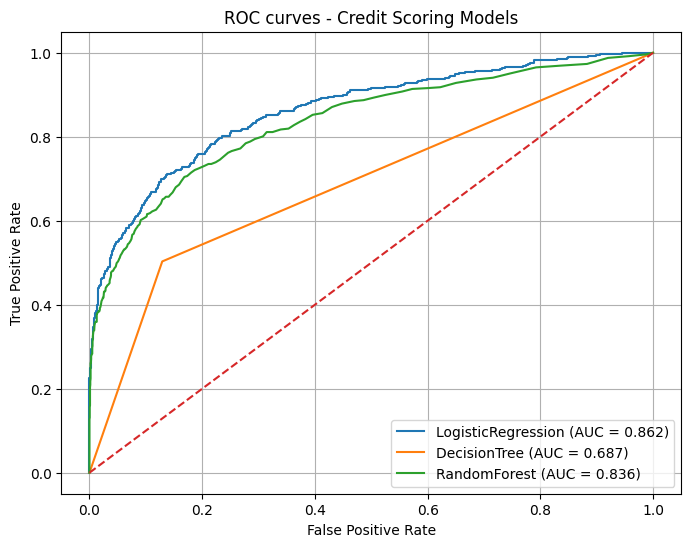


Model performance summary:
                     precision    recall        f1   roc_auc  accuracy
model                                                                
LogisticRegression   0.839552  0.462012  0.596026  0.862108    0.8780
DecisionTree         0.485149  0.503080  0.493952  0.686960    0.7992
RandomForest         0.750831  0.464066  0.573604  0.836377    0.8656

Random Forest feature importances:
 payment_history_score            0.209734
debt_to_income                   0.144315
credit_utilization               0.140895
total_debt                       0.106367
income                           0.084183
credit_limit                     0.082311
age                              0.065162
employment_years                 0.043731
months_since_last_delinquency    0.043642
num_open_accounts                0.038064
delinquencies_2yrs               0.022335
late_payments                    0.019262
dtype: float64

Logistic Regression coefficients (ranked by absolute value):
 de

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_fscore_support, confusion_matrix
)
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- 1) Synthetic dataset generation (10k samples) ---
n = 10000
income = np.random.lognormal(mean=10.5, sigma=0.8, size=n)  # annual income
age = np.random.randint(21, 75, size=n)
employment_years = np.clip(np.random.poisson(lam=5, size=n), 0, 50)
num_open_accounts = np.random.poisson(lam=3, size=n)
total_debt = np.random.lognormal(mean=9.5, sigma=1.2, size=n)
credit_limit = income * (np.random.uniform(0.5, 3.0, size=n)) + 5000
credit_utilization = np.clip(total_debt / (credit_limit + 1e-6), 0, 5.0)
delinquencies_2yrs = np.random.poisson(lam=0.3, size=n)
late_payments = np.random.poisson(lam=0.8, size=n)
months_since_last_delinquency = np.where(
    delinquencies_2yrs==0, 999, np.random.randint(1,60,size=n)
)
payment_history_score = np.clip(
    100 - (delinquencies_2yrs*20 + late_payments*5 + credit_utilization*10), 0, 100
)
debt_to_income = total_debt / (income + 1e-6)

risk_score = (
    0.6*credit_utilization +
    0.8*delinquencies_2yrs +
    0.4*late_payments +
    0.5*debt_to_income -
    0.02*employment_years -
    0.001*income/1000 -
    0.03*payment_history_score
)

prob_default = 1 / (1 + np.exp(-risk_score + 0.5))
y = np.random.binomial(1, np.clip(prob_default, 0.001, 0.999))

df = pd.DataFrame({
    "income": np.round(income,2),
    "age": age,
    "employment_years": employment_years,
    "num_open_accounts": num_open_accounts,
    "total_debt": np.round(total_debt,2),
    "credit_limit": np.round(credit_limit,2),
    "credit_utilization": np.round(credit_utilization,3),
    "debt_to_income": np.round(debt_to_income,3),
    "delinquencies_2yrs": delinquencies_2yrs,
    "late_payments": late_payments,
    "months_since_last_delinquency": months_since_last_delinquency,
    "payment_history_score": np.round(payment_history_score,2),
    "default": y
})

print("Sample data:\n", df.head())

# --- 2) Train/test split ---
X = df.drop(columns=["default"])
y = df["default"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

numeric_features = X.columns.tolist()
scaler = StandardScaler()

# --- 3) Pipelines for models ---
pipe_lr = Pipeline([
    ("scaler", scaler),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
pipe_dt = Pipeline([
    ("scaler", scaler),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])
pipe_rf = Pipeline([
    ("scaler", scaler),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
])

# --- 4) Train models ---
pipe_lr.fit(X_train, y_train)
pipe_dt.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

models = {"LogisticRegression": pipe_lr, "DecisionTree": pipe_dt, "RandomForest": pipe_rf}

# --- 5) Evaluate models ---
results = []
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary', zero_division=0
    )
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    results.append({
        "model": name,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "accuracy": report["accuracy"]
    })

plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves - Credit Scoring Models")
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame(results).set_index("model")
print("\nModel performance summary:\n", results_df)

# --- 6) Feature importance / coefficients ---
rf = pipe_rf.named_steps["clf"]
importances = pd.Series(rf.feature_importances_, index=numeric_features).sort_values(ascending=False)
print("\nRandom Forest feature importances:\n", importances)

lr = pipe_lr.named_steps["clf"]
coeffs = pd.Series(lr.coef_[0], index=numeric_features).sort_values(key=abs, ascending=False)
print("\nLogistic Regression coefficients (ranked by absolute value):\n", coeffs)

# --- 7) Confusion matrix for best model ---
best_model_name = results_df["roc_auc"].idxmax()
best_model = models[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))
cm_df = pd.DataFrame(cm, index=["Actual_NoDefault","Actual_Default"], columns=["Pred_NoDefault","Pred_Default"])
print(f"\nConfusion matrix - {best_model_name}:\n", cm_df)
